# MEA analyzer pipeline

## Part 1: Setup & Initialization

### Project root setup, core libraries and project modules - Please read carefully the text instructions

This part should be unchanged by users except maybe paths. Its job is to guarantee:

- Correct project root
- Correct imports
- Reproducibility
- No silent path bugs

In [1]:
# =========================
# PROJECT ROOT SETUP
# =========================
from pathlib import Path
import sys

# Current notebook location
HERE = Path.cwd().resolve()

# Find project root by locating "src" folder
PROJECT_ROOT = next(
    p for p in [HERE, *HERE.parents]
    if (p / "src").exists()
)

# Add project root to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Notebook directory:", HERE)
print("Project root:", PROJECT_ROOT)
print("src exists?", (PROJECT_ROOT / "src").exists())

Notebook directory: D:\Vitor_2025\mea_project\notebooks
Project root: D:\Vitor_2025\mea_project
src exists? True


In [2]:
# =========================
# CORE LIBRARIES
# =========================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns  # optional, used later for aesthetics

# Global plotting defaults
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [3]:
# =========================
# PROJECT MODULES
# =========================

# Configuration
from src.config_handler import ConfigHandler

# Data ingestion & organization
from src.data_loader import load_mea_csv_well_averages
from src.data_organizer import DataOrganizer

# QC & preprocessing
from src.qc.outliers import (
    OutlierSpec,
    flag_outliers,
    get_outliers_table,
    apply_outlier_filter
)

# Normalization
from src.analysis.normalization import baseline_normalize

# Visualization
from src.visualization.plot_plate_layout import plot_plate_layout
from src.visualization.timecourse import plot_metric_timecourse

# Export
from src.io.table_export import export_metric_tables_wide

print("All project modules imported successfully.")

All project modules imported successfully.


In [4]:
# =========================
# PROJECT PATHS
# =========================

CONFIG_DIR = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
FIGURES_DIR = PROJECT_ROOT / "figures"

# Optional processed data directory
PROCESSED_DIR = DATA_DIR / "processed"

# Create directories if missing
for d in [OUTPUTS_DIR, FIGURES_DIR, PROCESSED_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Config dir:", CONFIG_DIR)
print("Data dir:", DATA_DIR)
print("Outputs dir:", OUTPUTS_DIR)
print("Figures dir:", FIGURES_DIR)
print("Processed dir:", PROCESSED_DIR)

Config dir: D:\Vitor_2025\mea_project\config
Data dir: D:\Vitor_2025\mea_project\data
Outputs dir: D:\Vitor_2025\mea_project\outputs
Figures dir: D:\Vitor_2025\mea_project\figures
Processed dir: D:\Vitor_2025\mea_project\data\processed


### The next two cells should be edited by users to choose plate configuration and global analysis switches

In [5]:
# =========================
# LOAD CONFIGURATIONS
# =========================

# Metrics configuration
config_handler = ConfigHandler(PROJECT_ROOT)
metrics_config = config_handler.load_metrics_config()

# Experiment configuration (USER EDITS THIS)
CONFIG_PATH = CONFIG_DIR / "Plate_VPA.yaml" # <-- CHANGE THIS TO YOUR PLATE CONFIGURATION FILE

if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"Experiment config not found: {CONFIG_PATH}")

print("Using experiment config:", CONFIG_PATH)

✓ Loaded metrics config from: D:\Vitor_2025\mea_project\config\metrics_config.yaml
Using experiment config: D:\Vitor_2025\mea_project\config\Plate_VPA.yaml


In [6]:
# =========================
# USER ANALYSIS OPTIONS
# =========================

# Export tables
EXPORT_MODE = "both"          # <-- CHANGE THIS TO YOUR CHOICE "raw", "normalized", or "both"

# Outlier handling
OUTLIER_METHOD = "zscore"     # <-- CHANGE THIS TO YOUR CHOICE "zscore", "iqr", "mad"

OUTLIER_Z = 3.0               # <-- CHANGE THIS TO YOUR CHOICE (Z score value to detect outliers)

REMOVE_OUTLIERS = True        # <-- CHANGE THIS TO YOUR CHOICE "True" = Remove flagged outliers || "False" = Keep flagged outliers

# Normalization
NORMALIZE_TO_BASELINE = True  # <-- CHANGE THIS TO YOUR CHOICE "True" = Plot after outlier removal is normalized to baseline || "False" = Plot after outlier removal uses raw values

BASELINE_PREFIX = "0_"        # baseline files start with "0_"

print("EXPORT_MODE:", EXPORT_MODE)
print("OUTLIER_METHOD:", OUTLIER_METHOD)
print("REMOVE_OUTLIERS:", REMOVE_OUTLIERS)
print("NORMALIZE_TO_BASELINE:", NORMALIZE_TO_BASELINE)

EXPORT_MODE: both
OUTLIER_METHOD: zscore
REMOVE_OUTLIERS: True
NORMALIZE_TO_BASELINE: True


## Part 2: Validation of experiment details and plate configuration

In [7]:
# =========================
# LOAD EXPERIMENT CONFIG
# =========================
import yaml

with open(CONFIG_PATH, "r") as f:
    experiment_config = yaml.safe_load(f)

experiment_info = experiment_config.get("experiment", {})
conditions = experiment_config.get("conditions", {})
time_points = experiment_config.get("time_points", [])

print("Plate ID:", experiment_info.get("plate_id", "UNKNOWN"))
print("Data directory:", experiment_info.get("data_dir", "UNKNOWN"))
print("Number of conditions:", len(conditions))
print("Conditions:")
for name, info in conditions.items():
    print(f"  - {name}: {len(info['wells'])} wells")

Plate ID: Plate_VPA
Data directory: data/raw/
Number of conditions: 3
Conditions:
  - aCSF: 4 wells
  - aCSF VPA unfiltered: 4 wells
  - aCSF VPA filtered 1x: 4 wells


In [8]:
# =========================
# VALIDATE WELL ASSIGNMENTS
# =========================

VALID_ROWS = {"A", "B", "C", "D"}
VALID_COLS = {"1", "2", "3", "4", "5", "6"}

def is_valid_well(well):
    return (
        len(well) in (2, 3)
        and well[0] in VALID_ROWS
        and well[1:] in VALID_COLS
    )

all_wells = []
errors = []

for cond, info in conditions.items():
    for w in info["wells"]:
        if not is_valid_well(w):
            errors.append(f"Invalid well name: {w} (condition: {cond})")
        all_wells.append(w)

# Check duplicates
from collections import Counter
counts = Counter(all_wells)
duplicates = [w for w, c in counts.items() if c > 1]

if errors:
    print("❌ WELL FORMAT ERRORS:")
    for e in errors:
        print("  ", e)

if duplicates:
    print("❌ DUPLICATE WELL ASSIGNMENTS:")
    for w in duplicates:
        print("  ", w)

if not errors and not duplicates:
    print("✓ Well assignments validated successfully.")

✓ Well assignments validated successfully.


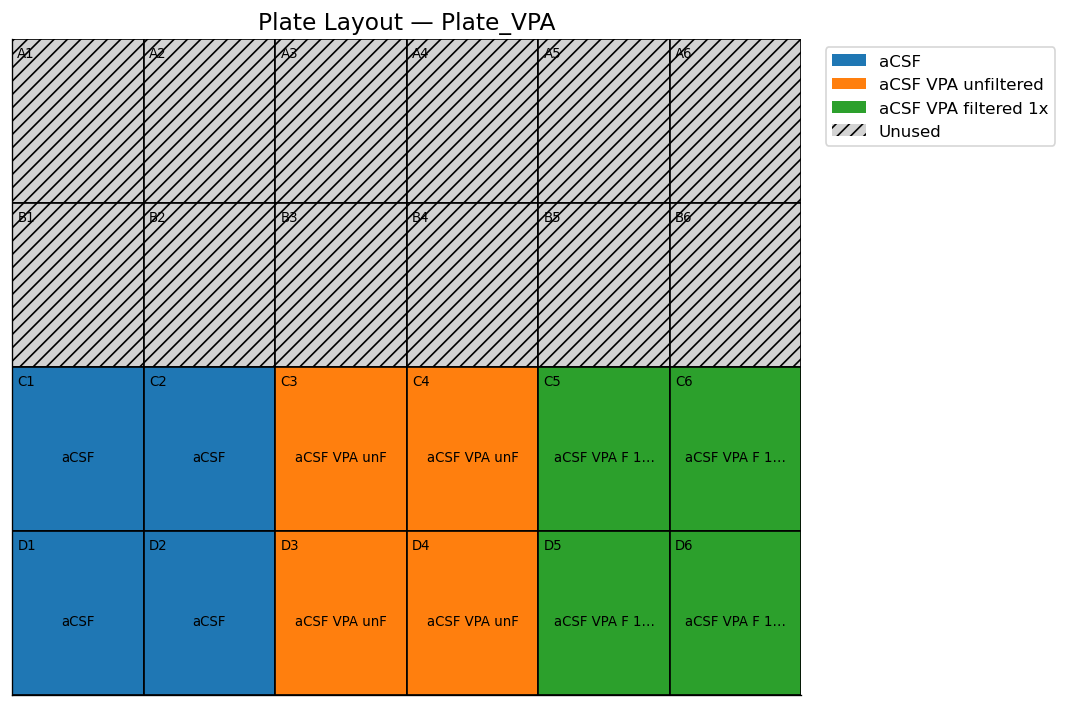

In [9]:
# =========================
# PLATE LAYOUT VISUALIZATION
# =========================

fig = plot_plate_layout(CONFIG_PATH)
plt.show()

In [10]:
# =========================
# TIME POINT LABELS
# =========================

if not time_points:
    print("No time points defined in config.")
    timepoint_labels = {}
else:
    timepoint_labels = {tp["index"]: tp["label"] for tp in time_points}
    print("Time point labels:")
    for k, v in timepoint_labels.items():
        print(f"  {k}: {v}")

Time point labels:
  0: Baseline
  1: 0h
  2: 15m


In [11]:
# =========================
# USER CONFIRMATION
# =========================

print("\nQC CHECKLIST:")
print("✓ Plate layout visually confirmed")
print("✓ Conditions and wells verified")
print("✓ Time points verified")

print("\nIf anything above is wrong:")
print("  → Stop here")
print("  → Fix the experiment config")
print("  → Restart the notebook\n")


QC CHECKLIST:
✓ Plate layout visually confirmed
✓ Conditions and wells verified
✓ Time points verified

If anything above is wrong:
  → Stop here
  → Fix the experiment config
  → Restart the notebook



## Part 3: Data loading & Master table

In [12]:
# =========================
# LOCATE RAW DATA FILES
# =========================

DATA_PATH = PROJECT_ROOT / experiment_info["data_dir"]

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data directory not found: {DATA_PATH}")

# Collect CSV files
csv_files = sorted(
    DATA_PATH.glob("*.csv"),
    key=lambda p: int(p.name.split("_")[0])  # assumes 0_, 1_, 2_, ...
)

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(" -", f.name)

# Baseline check
if not csv_files or not csv_files[0].name.startswith(BASELINE_PREFIX):
    raise ValueError(
        f"First file must be baseline and start with '{BASELINE_PREFIX}'. "
        f"Found: {csv_files[0].name if csv_files else 'NONE'}"
    )

Found 3 CSV files:
 - 0_Baseline(000)(000).csv
 - 1_VPA(000)(000).csv
 - 2_VPA(001)(000).csv


In [13]:
# =========================
# INITIALIZE DATA ORGANIZER
# =========================

organizer = DataOrganizer(
    experiment_config_path=CONFIG_PATH,
    config_handler=config_handler
)

print("DataOrganizer initialized successfully.")

✓ Loaded experiment config: Plate_VPA.yaml
✓ Created well mapping: 12 wells across 3 conditions
DataOrganizer initialized successfully.


In [14]:
# =========================
# BUILD MASTER DATAFRAME
# =========================

master_df = organizer.create_master_dataframe(
    data_loader_func=load_mea_csv_well_averages,
    verbose=True
)

print("\nMaster dataframe created.")
print("Shape:", master_df.shape)
print("Columns:", list(master_df.columns))

# Expected columns: plate_id | time_point | well | condition | condition_color | metric | metric_type | value


DISCOVERED CSV FILES
  Time point 0: 0_Baseline(000)(000).csv
  Time point 1: 1_VPA(000)(000).csv
  Time point 2: 2_VPA(001)(000).csv


LOADING AND ORGANIZING DATA

Processing time point 0: 0_Baseline(000)(000).csv
'Well Averages' found at line 121
Loaded 44 metrics for 24 wells
  ✓ Loaded 1056 rows

Processing time point 1: 1_VPA(000)(000).csv
'Well Averages' found at line 121
Loaded 44 metrics for 24 wells
  ✓ Loaded 1056 rows

Processing time point 2: 2_VPA(001)(000).csv
'Well Averages' found at line 121
Loaded 44 metrics for 24 wells
  ✓ Loaded 1056 rows

MASTER DATAFRAME CREATED
Total rows: 3168
Unique time points: 3
Unique metrics: 44
Unique wells: 24
Unique conditions (non-NaN): 3
Rows with unassigned condition (NaN): 1584


Master dataframe created.
Shape: (3168, 8)
Columns: ['plate_id', 'time_point', 'well', 'condition', 'condition_color', 'metric', 'value', 'metric_type']


In [15]:
# =========================
# MASTER DF SANITY CHECKS
# =========================

print("\nValue summary:")
display(master_df["value"].describe())

print("\nMetric counts:")
display(master_df["metric"].value_counts())

print("\nCondition counts:")
display(master_df["condition"].value_counts(dropna=False))


Value summary:


count     3036.000000
mean       613.451293
std       4474.514237
min          0.000000
25%          0.311241
50%          3.833544
75%         25.549415
max      76519.000000
Name: value, dtype: float64


Metric counts:


metric
Number of Spikes                                        72
Mean Firing Rate (Hz)                                   72
Burst Percentage - Std                                  72
Number of Network Bursts                                72
Network Burst Frequency (Hz)                            72
Network Burst Duration - Avg (sec)                      72
Network Burst Duration - Std (sec)                      72
Number of Spikes per Network Burst - Avg                72
Number of Spikes per Network Burst - Std                72
Number of Elecs Participating in Burst - Avg            72
Number of Elecs Participating in Burst - Std            72
Number of Spikes per Network Burst per Channel - Avg    72
Number of Spikes per Network Burst per Channel - Std    72
Network Burst Percentage                                72
Network IBI Coefficient of Variation                    72
Network ISI Coefficient of Variation                    72
Network Normalized Duration IQR                  


Condition counts:


condition
NaN                     1584
aCSF                     528
aCSF VPA unfiltered      528
aCSF VPA filtered 1x     528
Name: count, dtype: int64

In [16]:
# =========================
# PREVIEW DATA
# =========================

display(master_df.head(10)) # <-- Change the number to the desired number of rows to show, if needed.

,plate_id,time_point,well,condition,condition_color,metric,value,metric_type
0,Plate_VPA,0,A1,NaN,NaN,Number of Spikes,13631.000000,unknown
1,Plate_VPA,0,A1,NaN,NaN,Mean Firing Rate (Hz),2.842160,unknown
2,Plate_VPA,0,A1,NaN,NaN,Number of Active Electrodes,12.000000,count
3,Plate_VPA,0,A1,NaN,NaN,Weighted Mean Firing Rate (Hz),3.776758,rate
4,Plate_VPA,0,A1,NaN,NaN,ISI Coefficient of Variation - Avg,9.676731,unknown
5,Plate_VPA,0,A1,NaN,NaN,Number of Bursts,635.000000,count
6,Plate_VPA,0,A1,NaN,NaN,Number of Bursting Electrodes,12.000000,unknown
7,Plate_VPA,0,A1,NaN,NaN,Burst Duration - Avg (s),0.236435,unknown
8,Plate_VPA,0,A1,NaN,NaN,Burst Duration - Std (s),0.068170,unknown
9,Plate_VPA,0,A1,NaN,NaN,Number of Spikes per Burst - Avg,22.577679,unknown


## Part 4: QC & Outlier detection

In [17]:
# =========================
# OUTLIER DETECTION SETUP
# =========================

outlier_spec = OutlierSpec(
    method=OUTLIER_METHOD,
    threshold=OUTLIER_Z,
    group_cols=("plate_id", "metric", "time_point", "condition"),
    value_col="value"
)

print("Outlier detection spec:")
print(outlier_spec)

Outlier detection spec:
OutlierSpec(method='zscore', threshold=3.0, min_group_n=3, group_cols=('plate_id', 'metric', 'time_point', 'condition'), value_col='value')


In [18]:
# =========================
# FLAG OUTLIERS (NON-DESTRUCTIVE)
# =========================

df_flagged = flag_outliers(
    master_df,
    spec=outlier_spec
)

print("Outlier flagging completed.")
print("Total flagged outliers:", df_flagged["is_outlier"].sum())

Outlier flagging completed.
Total flagged outliers: 0


D:\Vitor_2025\mea_project\src\qc\outliers.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = out.groupby(list(spec.group_cols), group_keys=False).apply(_process_group)


In [19]:
# =========================
# OUTLIERS TABLE
# =========================

outliers_table = get_outliers_table(df_flagged)

print("Number of outliers detected:", len(outliers_table))
display(outliers_table.head(20))

Number of outliers detected: 0


,plate_id,condition,well,time_point,metric,value,outlier_score,outlier_group_n,outlier_method,outlier_threshold


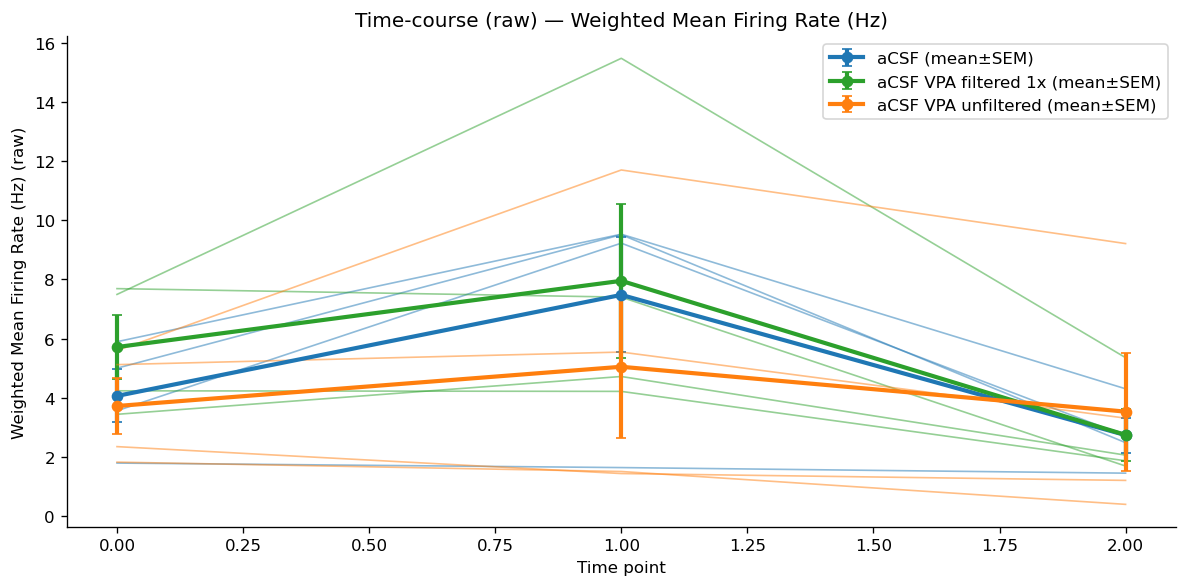

In [20]:
# =========================
# RAW DATA QC PLOT (WITH OUTLIERS)
# =========================

METRIC = "Weighted Mean Firing Rate (Hz)"  # user changes this

fig = plot_metric_timecourse(
    df_flagged,
    metric=METRIC
)

plt.show()

In [21]:
# =========================
# APPLY OUTLIER FILTER (OPTIONAL)
# =========================

if REMOVE_OUTLIERS:
    df_filtered = apply_outlier_filter(df_flagged)
    print("Outliers removed (values set to NaN).")
    print("NaNs after filtering:", df_filtered["value"].isna().sum())
else:
    df_filtered = df_flagged.copy()
    print("Outliers retained.")

Outliers removed (values set to NaN).
NaNs after filtering: 0


In [22]:
# =========================
# SAVE QC TABLES
# =========================

qc_flagged_path = OUTPUTS_DIR / "master_flagged_long.csv"
qc_filtered_path = OUTPUTS_DIR / "master_filtered_long.csv"

df_flagged.to_csv(qc_flagged_path, index=False)
df_filtered.to_csv(qc_filtered_path, index=False)

print("QC tables saved:")
print(" -", qc_flagged_path)
print(" -", qc_filtered_path)

QC tables saved:
 - D:\Vitor_2025\mea_project\outputs\master_flagged_long.csv
 - D:\Vitor_2025\mea_project\outputs\master_filtered_long.csv


## Part 5: Baseline normalization

- Values are normalized to the baseline (time point 0) on a per-well basis:

- Normalized value = Value / Baseline Value

- Wells with missing or zero baseline values are excluded from normalization, because division would be undefined or biologically meaningless.

In [23]:
# =========================
# BASELINE NORMALIZATION
# =========================

if NORMALIZE_TO_BASELINE:
    df_norm, baseline_qc = baseline_normalize(
    df_filtered,
    baseline_time_point=0,
    value_col="value",
    normalized_col="value_norm",
    method="ratio",                 # ratio is usually the cleanest (baseline=1)
    exclude_zero_baseline=True,
    keep_excluded_rows=False,
    return_qc_table=True
)

    print("Baseline normalization completed.")
    print("Wells excluded due to baseline issues:", baseline_qc.shape[0])
else:
    df_norm = df_filtered.copy()
    print("Baseline normalization skipped.")

Baseline normalization completed.
Wells excluded due to baseline issues: 0


In [24]:
# =========================
# BASELINE QC TABLE
# =========================

if NORMALIZE_TO_BASELINE:
    print("Baseline exclusion reasons:")
    display(baseline_qc)

Baseline exclusion reasons:


,plate_id,well,metric,baseline_value,exclusion_reason


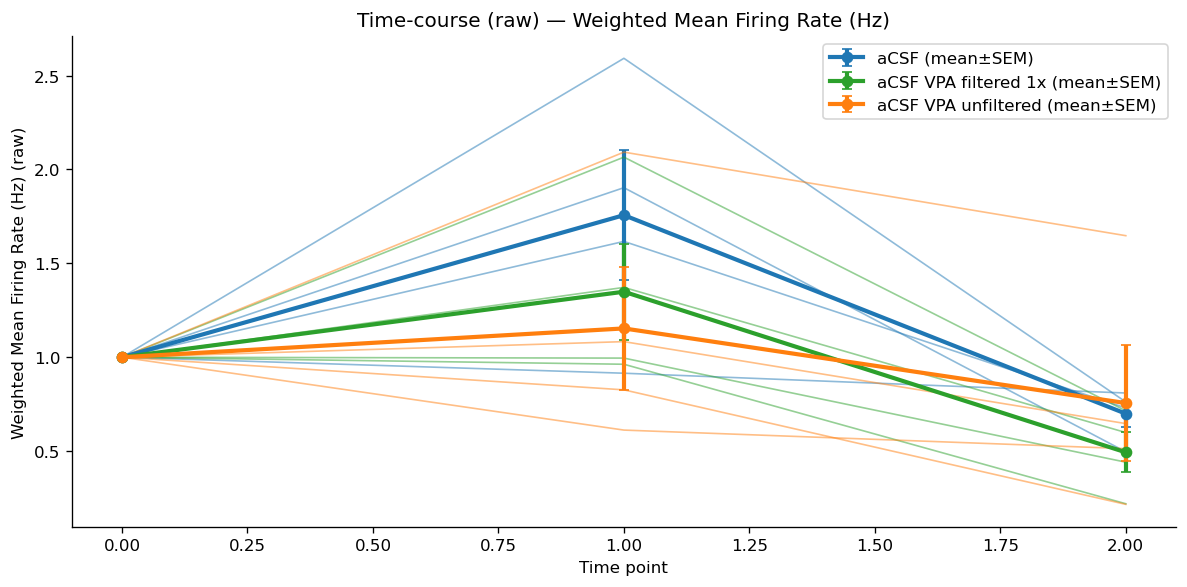

In [25]:
# =========================
# NORMALIZED TIMECOURSE PLOT
# =========================

if NORMALIZE_TO_BASELINE:
    METRIC = "Weighted Mean Firing Rate (Hz)"  # user-selectable

    fig = plot_metric_timecourse(
        df_norm,
        metric=METRIC,
        value_col="value_norm"
    )

    plt.show()

In [26]:
# =========================
# SAVE NORMALIZED MASTER TABLE
# =========================

if NORMALIZE_TO_BASELINE:
    norm_master_path = OUTPUTS_DIR / "master_normalized_long.csv"
    df_norm.to_csv(norm_master_path, index=False)
    print("Normalized master table saved to:")
    print(norm_master_path)

Normalized master table saved to:
D:\Vitor_2025\mea_project\outputs\master_normalized_long.csv


## Part 6: Statistics (Comparisons within timepoint)

### The next cell should be edited by users to set statistics options

In [27]:
# =========================
# STATISTICS OPTIONS
# =========================

# Which data to use for statistics
STATS_MODE = "normalized"            # <-- CHANGE THIS TO YOUR CHOICE "raw" or "normalized"

# Statistical test family
STATS_TEST_FAMILY = "nonparametric"  # <-- CHANGE THIS TO YOUR CHOICE "parametric" or "nonparametric"

# Multiple testing correction
P_ADJUST_METHOD = "fdr_bh"           # <-- CHANGE THIS TO YOUR CHOICE "bonferroni", "holm", "fdr_bh"

# Minimum number of wells per condition
MIN_N_PER_GROUP = 3                  # <-- CHANGE THIS TO YOUR CHOICE (Minimum of 3 wells recommended)

print("STATS_MODE:", STATS_MODE)
print("STATS_TEST_FAMILY:", STATS_TEST_FAMILY)
print("P_ADJUST_METHOD:", P_ADJUST_METHOD)
print("MIN_N_PER_GROUP:", MIN_N_PER_GROUP)

STATS_MODE: normalized
STATS_TEST_FAMILY: nonparametric
P_ADJUST_METHOD: fdr_bh
MIN_N_PER_GROUP: 3


In [28]:
# =========================
# SELECT DATA FOR STATS
# =========================

if STATS_MODE == "normalized":
    if "value_norm" not in df_norm.columns:
        raise ValueError("Normalized data requested but df_norm is missing.")
    stats_df = df_norm
    VALUE_COL = "value_norm"
else:
    stats_df = df_filtered
    VALUE_COL = "value"

print("Using value column:", VALUE_COL)

Using value column: value_norm


In [29]:
# =========================
# INITIALIZE STATS SPEC
# =========================

from src.statistics.timepoint_tests import (
    TimepointStatsSpec,
    compare_conditions_at_timepoint
)

stats_spec = TimepointStatsSpec(
    test_family=STATS_TEST_FAMILY,
    p_adjust_method=P_ADJUST_METHOD,
    value_col=VALUE_COL
)

print(stats_spec)

TimepointStatsSpec(test_family='nonparametric', p_adjust_method='fdr_bh', value_col='value_norm')


### In the next cell, select which metrics to analyze 

- Copy and paste the desired metrics into the analysis line of code
- Metric names must match exactly (including spaces and units)
- Strings inside quotes, separated by commas

- Here you can select an specific timepoint to analyze
- Or, in the other next cell, analyze all timepoints

  - "Number of Active Electrodes",
  - "Number of Bursts",
  - "Number of Network Bursts",
  - "Weighted Mean Firing Rate (Hz)",
  - "Burst Frequency - Avg (Hz)",
  - "Network Burst Frequency",
  - "Burst Duration - Avg (sec)",
  - "Network Burst Duration - Avg (sec)",
  - "Network IBI Coefficient of Variation",
  - "Synchrony Index"

In [30]:
# =========================
# RUN STATS: SINGLE TIME POINT
# =========================

METRIC = "Weighted Mean Firing Rate (Hz)"  # user selects
TIME_POINT = 1                             # user selects (e.g., post-treatment)

desc_df, omnibus_df, pairwise_df = compare_conditions_at_timepoint(
    stats_df,
    metric=METRIC,
    time_point=TIME_POINT,
    spec=stats_spec,
    min_n_per_group=MIN_N_PER_GROUP
)

print("Descriptive statistics:")
display(desc_df)

print("Omnibus test:")
display(omnibus_df)

print("Pairwise comparisons:")
display(pairwise_df)

Descriptive statistics:


,condition,n,mean,sem,median,std
0,aCSF,4,1.756480,0.347217,1.759715,0.694434
1,aCSF VPA filtered 1x,4,1.348797,0.256263,1.183585,0.512525
2,aCSF VPA unfiltered,4,1.153396,0.327369,0.954710,0.654737


Omnibus test:


,metric,time_point,plate_id,test_family,test,statistic,p_value,k_groups,min_n_per_group
0,Weighted Mean Firing Rate (Hz),1,ALL,nonparametric,kruskal_wallis,1.384615,0.50042,3,3


Pairwise comparisons:


,metric,time_point,plate_id,test_family,test,condition_a,condition_b,n_a,n_b,statistic,p_value,effect,p_adj
0,Weighted Mean Firing Rate (Hz),1,ALL,nonparametric,mannwhitney_u,aCSF,aCSF VPA filtered 1x,4,4,10.0,0.685714,NaN,0.685714
1,Weighted Mean Firing Rate (Hz),1,ALL,nonparametric,mannwhitney_u,aCSF,aCSF VPA unfiltered,4,4,12.0,0.342857,NaN,0.685714
2,Weighted Mean Firing Rate (Hz),1,ALL,nonparametric,mannwhitney_u,aCSF VPA filtered 1x,aCSF VPA unfiltered,4,4,10.0,0.685714,NaN,0.685714


In [31]:
# =========================
# RUN STATS ACROSS TIME POINTS
# =========================

all_timepoints = sorted(stats_df["time_point"].unique())

all_desc = []
all_omnibus = []
all_pairwise = []

for tp in all_timepoints:
    try:
        d, o, p = compare_conditions_at_timepoint(
            stats_df,
            metric=METRIC,
            time_point=int(tp),
            spec=stats_spec,
            min_n_per_group=MIN_N_PER_GROUP
        )
        all_desc.append(d.assign(time_point=tp))
        all_omnibus.append(o)
        all_pairwise.append(p)
    except ValueError as e:
        print(f"Skipping time point {tp}: {e}")

desc_all_tp = pd.concat(all_desc, ignore_index=True)
omnibus_all_tp = pd.concat(all_omnibus, ignore_index=True)
pairwise_all_tp = pd.concat(all_pairwise, ignore_index=True)

print("Statistics computed across time points.")

Skipping time point 0: All numbers are identical in kruskal
Statistics computed across time points.


In [32]:
# =========================
# INSPECT AND SAVE STATISTICS TABLES
# =========================

desc_path = OUTPUTS_DIR / f"stats_descriptives_{METRIC.replace(' ', '_')}.csv"
omnibus_path = OUTPUTS_DIR / f"stats_omnibus_{METRIC.replace(' ', '_')}.csv"
pairwise_path = OUTPUTS_DIR / f"stats_pairwise_{METRIC.replace(' ', '_')}.csv"

desc_all_tp.to_csv(desc_path, index=False)
omnibus_all_tp.to_csv(omnibus_path, index=False)
pairwise_all_tp.to_csv(pairwise_path, index=False)

print("Statistics tables saved:")
print(" -", desc_path)
print(" -", omnibus_path)
print(" -", pairwise_path)

Statistics tables saved:
 - D:\Vitor_2025\mea_project\outputs\stats_descriptives_Weighted_Mean_Firing_Rate_(Hz).csv
 - D:\Vitor_2025\mea_project\outputs\stats_omnibus_Weighted_Mean_Firing_Rate_(Hz).csv
 - D:\Vitor_2025\mea_project\outputs\stats_pairwise_Weighted_Mean_Firing_Rate_(Hz).csv


## Part 7: Exports & Final outputs

In [33]:
# =========================
# EXPORT CLEAN TABLES (PRISM-FRIENDLY)
# =========================

exported_dirs = []
processed_dir = PROCESSED_DIR  # already defined earlier as PROJECT_ROOT/data/processed

if EXPORT_MODE in ("raw", "both"):
    raw_dir = export_metric_tables_wide(
        master_df,
        out_dir=processed_dir,
        config_handler=config_handler,
        mode="raw",
        timepoint_labels=timepoint_labels,
        drop_unassigned_wells=True
    )
    exported_dirs.append(raw_dir)

if EXPORT_MODE in ("normalized", "both"):
    if "value_norm" not in df_norm.columns:
        print("⚠ Normalized export requested, but normalization was not performed.")
    else:
        norm_dir = export_metric_tables_wide(
            df_norm,
            out_dir=processed_dir,
            config_handler=config_handler,
            mode="normalized",
            timepoint_labels=timepoint_labels,
            drop_unassigned_wells=True
        )
        exported_dirs.append(norm_dir)

print("Export complete. Tables written to:")
for d in exported_dirs:
    print(" -", d)

Export complete. Tables written to:
 - D:\Vitor_2025\mea_project\data\processed\Plate_VPA\raw
 - D:\Vitor_2025\mea_project\data\processed\Plate_VPA\normalized


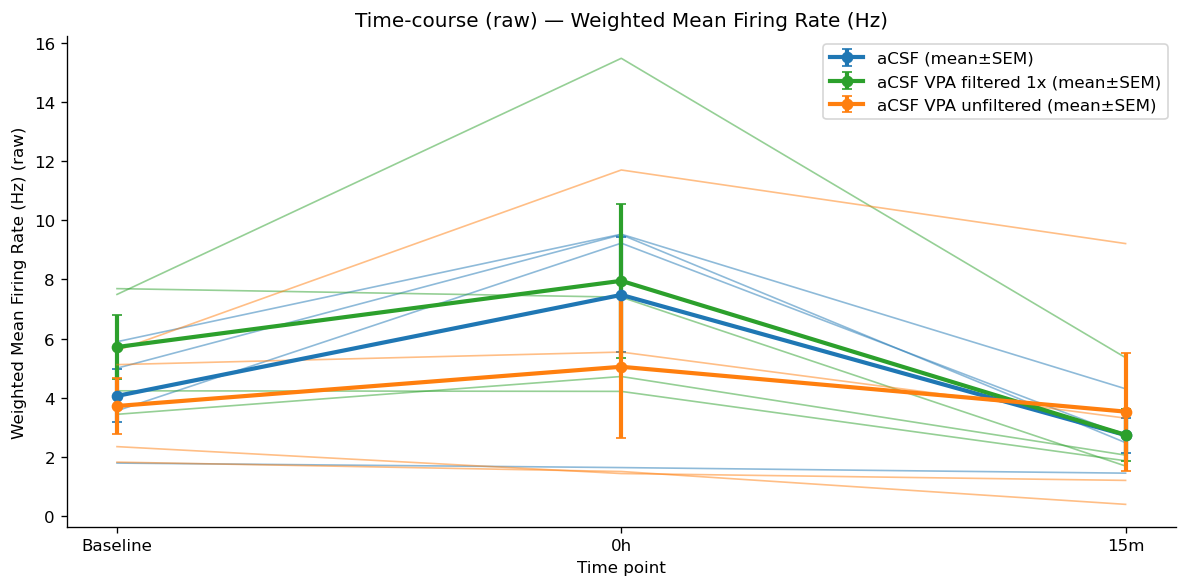

Saved: D:\Vitor_2025\mea_project\figures\RAW_Weighted_Mean_Firing_Rate_(Hz).png


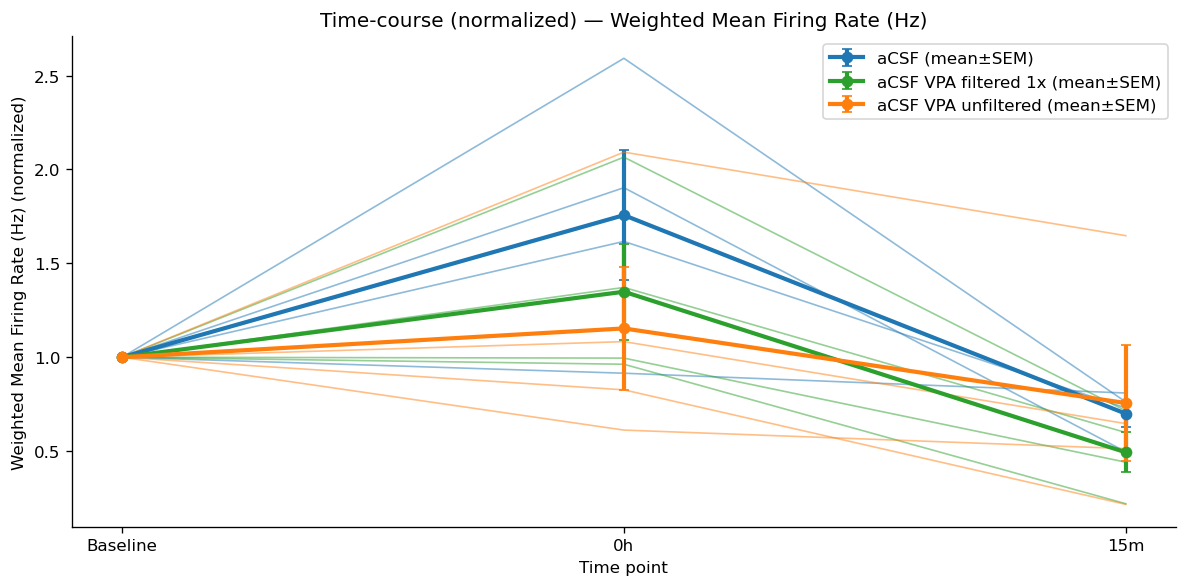

Saved: D:\Vitor_2025\mea_project\figures\NORM_Weighted_Mean_Firing_Rate_(Hz).png


In [34]:
# =========================
# EXPORT FIGURES FOR SELECTED METRIC
# =========================

safe_metric = METRIC.replace(" ", "_").replace("/", "-")

# RAW plot (post outlier handling)
fig_raw = plot_metric_timecourse(
    df_filtered,
    metric=METRIC,
    use_normalized=False,
    show_outliers=False,
    timepoint_labels=timepoint_labels
)
raw_fig_path = FIGURES_DIR / f"RAW_{safe_metric}.png"
fig_raw.savefig(raw_fig_path, dpi=300, bbox_inches="tight")

print("Saved:", raw_fig_path)

# NORMALIZED plot (if available)
if "value_norm" in df_norm.columns:
    fig_norm = plot_metric_timecourse(
        df_norm,
        metric=METRIC,
        use_normalized=True,
        show_outliers=False,
        timepoint_labels=timepoint_labels
    )
    norm_fig_path = FIGURES_DIR / f"NORM_{safe_metric}.png"
    fig_norm.savefig(norm_fig_path, dpi=300, bbox_inches="tight")
    print("Saved:", norm_fig_path)
else:
    print("Normalization not performed → normalized figure not saved.")

In [35]:
# =========================
# EXPORT MASTER TABLES (LONG FORMAT)
# =========================

master_df.to_csv(OUTPUTS_DIR / "master_raw_long.csv", index=False)
df_flagged.to_csv(OUTPUTS_DIR / "master_flagged_long.csv", index=False)
df_filtered.to_csv(OUTPUTS_DIR / "master_filtered_long.csv", index=False)

if "value_norm" in df_norm.columns:
    df_norm.to_csv(OUTPUTS_DIR / "master_normalized_long.csv", index=False)

print("Master tables exported to:", OUTPUTS_DIR)

Master tables exported to: D:\Vitor_2025\mea_project\outputs


In [36]:
# =========================
# FINAL RUN SUMMARY
# =========================

plate_id = experiment_info.get("plate_id", "UNKNOWN")
n_files = len(csv_files)
n_metrics = master_df["metric"].nunique()
n_timepoints = master_df["time_point"].nunique()
n_assigned_rows = master_df["condition"].notna().sum()

print("=" * 70)
print("MEA ANALYSIS RUN SUMMARY")
print("=" * 70)
print("Plate ID:", plate_id)
print("CSV files processed:", n_files)
print("Time points:", n_timepoints)
print("Metrics detected:", n_metrics)
print("Rows (assigned wells only):", n_assigned_rows)

# Outliers
if "is_outlier" in df_flagged.columns:
    print("Outliers flagged:", int(df_flagged["is_outlier"].sum()))
else:
    print("Outliers flagged: (no outlier column found)")

# Baseline exclusions
if NORMALIZE_TO_BASELINE and "baseline_qc" in globals():
    print("Wells excluded due to baseline issues:", len(baseline_qc))
else:
    print("Baseline exclusion table: not generated")

print("\nOutputs:")
print(" - Long tables:", OUTPUTS_DIR)
print(" - Figures:", FIGURES_DIR)
print(" - Prism tables:", PROCESSED_DIR)

print("=" * 70)
print("Done.")
print("=" * 70)

MEA ANALYSIS RUN SUMMARY
Plate ID: Plate_VPA
CSV files processed: 3
Time points: 3
Metrics detected: 44
Rows (assigned wells only): 1584
Outliers flagged: 0
Wells excluded due to baseline issues: 0

Outputs:
 - Long tables: D:\Vitor_2025\mea_project\outputs
 - Figures: D:\Vitor_2025\mea_project\figures
 - Prism tables: D:\Vitor_2025\mea_project\data\processed
Done.
